# Imports

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import f1_score,recall_score, precision_score

import ast

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

%matplotlib inline

# Path and Load Data 

In [6]:
data = pd.read_csv('/content/technology_[actual_size=4976]_processed_merge.csv').technology
data = pd.DataFrame(data=data)
data.head() 

,technology
0,"['food', 'lab', 'egyptian', 'cloud', 'kitchen'..."
1,"['tesla', 'say', 'also', 'investig', 'feder', ..."
2,"['top', 'softbank', 'latam', 'partner', 'leav'..."
3,"['ant', 'group', 'buy', ""singapore'"", '2c2p', ..."
4,"['indian', 'crypto', 'exchang', 'coindcx', 'to..."


In [7]:
INTEREST_positive_tweets = data[:4968] 
print('INTEREST tweets size :', len(INTEREST_positive_tweets))
INTEREST_negative_tweets = data[4968:] 
print('non-INTEREST tweets size :', len(INTEREST_negative_tweets))

INTEREST tweets size : 4968
non-INTEREST tweets size : 5008


* Train test split: 20% will be in the test set, and 80% in the training set.


In [8]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = INTEREST_positive_tweets[4000:]
train_pos = INTEREST_positive_tweets[:4000]

test_neg = INTEREST_negative_tweets[4000:]
train_neg = INTEREST_negative_tweets[:4000]

In [9]:
train_x = pd.concat([train_pos, train_neg], axis=0) 
test_x = pd.concat([test_pos, test_neg], axis=0)

- Create the numpy array of positive labels and negative labels.

In [10]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [11]:
print('train shape:', train_y.shape)
print('test shape:', test_y.shape)

train shape: (8000, 1)
test shape: (1976, 1)


# Vocabulary for Politics Dataset 

In [12]:
def generate_tweets_list(dataframe_single):
    train_x_arr = [] 
    for index, row in dataframe_single.iterrows(): 
        for a in row.values: 
            train_x_arr.append(ast.literal_eval(a))
            
    return train_x_arr

In [13]:
train_x_arr = generate_tweets_list(train_x)

In [14]:
def build_freqs(train_x, train_y):
    
    yslist = np.squeeze(train_y).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, train_x):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [15]:
freqs = build_freqs(train_x_arr, train_y) 
train_x_arr = generate_tweets_list(train_x)

In [16]:
len(freqs)

13916

In [17]:
freqs_vis = np.ndarray((1,2))

for (word, label), value in freqs.items(): 
    if label == 1.0: 
        freqs_vis = np.append(freqs_vis, [[word, value]], axis=0)

        
freqs_vis

array([['0.0', '0.0'],
       ['food', '17'],
       ['lab', '18'],
       ...,
       ['framework', '1'],
       ['raireport', '1'],
       ['rcp', '2']], dtype='<U32')

In [18]:
freqs_vis = np.delete(freqs_vis, 0, axis=0)

In [19]:
freqs_vis = pd.DataFrame(data=freqs_vis, columns=['word', 'frequency'])
freqs_vis.head()

,word,frequency
0,food,17
1,lab,18
2,egyptian,1
3,cloud,27
4,kitchen,2


In [20]:
freqs_vis['frequency'] = freqs_vis['frequency'].astype('int')
freqs_vis = freqs_vis.nlargest(columns='frequency', n=20).iloc[2:,:]
freqs_vis

,word,frequency
63,startup,205
6,rais,201
125,get,172
185,app,170
169,appl,165
202,game,162
177,googl,154
51,us,150
233,launch,141
313,twitter,130


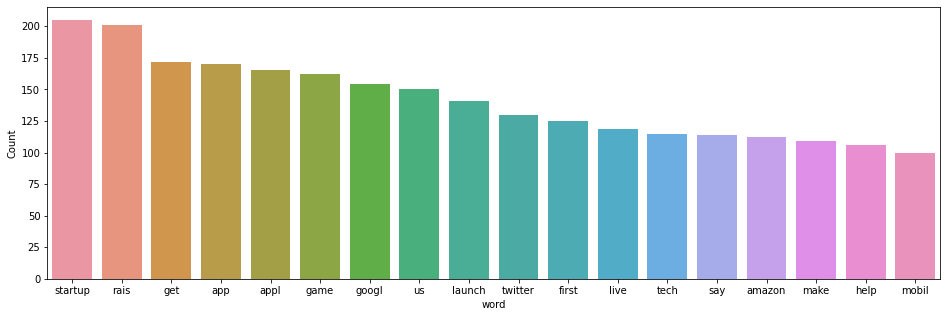

In [21]:
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=freqs_vis, x='word', y='frequency')
ax.set(ylabel = 'Count') 
plt.show() 

## Extract Features 
* Given a list of tweets, extract the features and store them in a matrix. Extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train the logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [22]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet 
        freqs: a dictionary corresponding to the frequencies of each tuple 
    Output:
        x: a feature vector of dimension (1, 3)
    '''
    x = np.zeros((1, 3)) 
    x[0,0] = 1 # bias term  
    
    for word in tweet: 
        
        x[0,1] += freqs.get((word, 1.0), 0) 
        
        x[0,2] += freqs.get((word, 0.0), 0) 
        
    assert(x.shape == (1, 3))
    return x 

In [23]:
# Ex 
train_x_arr[0]

['food',
 'lab',
 'egyptian',
 'cloud',
 'kitchen',
 'provid',
 'rais',
 '5m',
 'pre-se',
 'expans']

In [24]:
extract_features(train_x_arr[0], freqs)

array([[  1., 315., 128.]])

In [25]:
extract_features(['asd', 'asd', 'asd'], freqs)

array([[1., 0., 0.]])

In [26]:
X = np.zeros((len(train_x_arr), 3))
for i in range(len(train_x_arr)):
    X[i, :]= extract_features(train_x_arr[i], freqs) 
    
X[:5]

array([[  1., 315., 128.],
       [  1., 188., 235.],
       [  1., 164., 186.],
       [  1., 200.,  90.],
       [  1., 811., 459.]])

In [27]:
y = train_y

In [28]:
X_sparse = coo_matrix(X)
X, X_sparse, y = shuffle(X, X_sparse, y, random_state=0)

y

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [29]:
X

array([[1.000e+00, 4.730e+02, 9.700e+01],
       [1.000e+00, 5.760e+02, 3.240e+02],
       [1.000e+00, 1.910e+02, 3.600e+02],
       ...,
       [1.000e+00, 7.880e+02, 4.060e+02],
       [1.000e+00, 1.467e+03, 1.311e+03],
       [1.000e+00, 1.588e+03, 1.528e+03]])

In [30]:
vis_X = pd.DataFrame(data=X, columns=['bias', 'positive', 'negative'])
vis_y = pd.DataFrame(data=y, columns=['target']) 

vis_data = pd.concat([vis_X, vis_y], axis=1) 

vis_data.head() 

,bias,positive,negative,target
0,1.0,473.0,97.0,1.0
1,1.0,576.0,324.0,1.0
2,1.0,191.0,360.0,0.0
3,1.0,457.0,36.0,1.0
4,1.0,604.0,391.0,1.0


<Figure size 720x720 with 0 Axes>

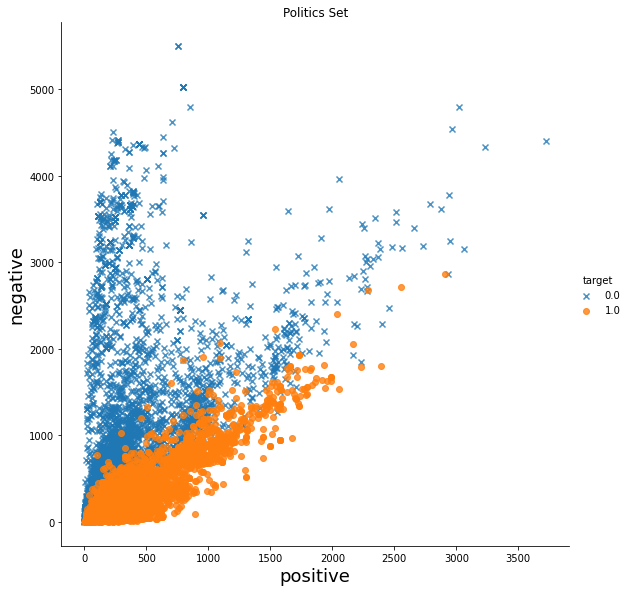

In [31]:
plt.figure(figsize=(10,10))
#plt.scatter(x='positive', y='negative', data=vis_data, c=vis_data.target, alpha=0.8, cmap='viridis', s=15)
sns.lmplot(x='positive', y='negative', data=vis_data, hue='target', fit_reg=False, height=8, markers=['x','o'])
plt.title('Politics Set')
plt.xlabel('positive', fontsize=18)
plt.ylabel('negative', fontsize=18) 
plt.show() 

# Classifier  1 : Logistic Regression 

* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 


# 1.1 Apply Logistic Regression and Cross - Validation 

* As a reminder, We have a balanced dataset. 

In [32]:
cross_val_score(LogisticRegression(), X, y.ravel())

array([0.865625, 0.869375, 0.871875, 0.88375 , 0.875625])

- We have very satisfying results. Let's do some hyper-parameter tuning.

# 1.2 Grid Search on Logistic Regression

In [33]:
%%time
gs_model = LogisticRegression(solver='liblinear') 
space = {
    'C': [1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

search = GridSearchCV(gs_model, space, scoring='accuracy', cv = 5) 
search.fit(X, y.ravel())  

CPU times: user 621 ms, sys: 50.7 ms, total: 671 ms
Wall time: 609 ms


In [34]:
print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)

Best Score: 0.88125
Best Hyperparameters: {'C': 0.001}


In [35]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008959,0.000571,0.000984,0.000059,0.0,{'C': 1e-10},0.539375,0.536875,0.543125,0.539375,0.537500,0.53925,0.002179,9
1,0.010357,0.001880,0.000720,0.000166,0.00001,{'C': 1e-05},0.861250,0.876875,0.878125,0.880000,0.877500,0.87475,0.006831,4
2,0.009964,0.000860,0.000578,0.000037,0.0001,{'C': 0.0001},0.868750,0.879375,0.881875,0.883750,0.881250,0.87900,0.005312,2
3,0.012679,0.001850,0.000711,0.000117,0.001,{'C': 0.001},0.869375,0.879375,0.885000,0.888125,0.884375,0.88125,0.006567,1
4,0.013006,0.000550,0.000596,0.000033,0.01,{'C': 0.01},0.868750,0.868125,0.874375,0.885000,0.882500,0.87575,0.006930,3
5,0.012964,0.000867,0.000620,0.000028,0.1,{'C': 0.1},0.866875,0.870000,0.872500,0.883750,0.879375,0.87450,0.006192,5
6,0.013014,0.000837,0.000609,0.000045,1,{'C': 1},0.865625,0.870000,0.872500,0.883750,0.879375,0.87425,0.006512,6
7,0.012761,0.000732,0.000603,0.000030,10,{'C': 10},0.865625,0.870000,0.872500,0.883750,0.879375,0.87425,0.006512,6
8,0.012755,0.000836,0.000603,0.000025,100,{'C': 100},0.865625,0.870000,0.872500,0.883750,0.879375,0.87425,0.006512,6


In [36]:
search.best_score_

0.88125

# Test Logistic Regression Model

In [37]:
test_x_arr = generate_tweets_list(test_x)

In [38]:
X_test = np.zeros((len(test_x_arr), 3))
for i in range(len(test_x_arr)):
    X_test[i, :]= extract_features(test_x_arr[i], freqs) 
    
X_test[:5]

array([[1.00e+00, 9.94e+02, 1.44e+03],
       [1.00e+00, 3.95e+02, 5.97e+02],
       [1.00e+00, 1.55e+02, 1.34e+02],
       [1.00e+00, 4.52e+02, 8.30e+02],
       [1.00e+00, 3.00e+01, 1.00e+01]])

In [39]:
search.best_estimator_.score(X_test, test_y.ravel())

0.6381578947368421

In [40]:
y_hat = search.best_estimator_.predict(X_test)
print("F1-Score is", f1_score(test_y.ravel(), y_hat))

F1-Score is 0.6603325415676959


In [41]:
y_hat = search.best_estimator_.predict(X_test)
print("Precision is", precision_score(test_y.ravel(), y_hat))

Precision is 0.6112576956904133


In [42]:
y_hat = search.best_estimator_.predict(X_test)
print("Recall is", recall_score(test_y.ravel(), y_hat))

Recall is 0.7179752066115702


# Classifier 2 : SVM 

In [43]:
clf_svm = SVC(kernel='linear') 
clf_svm.fit(X, y.ravel())

SVC(kernel='linear')

In [44]:
clf_svm.score(X_test, test_y.ravel())

0.604251012145749

In [45]:
clf_svm.score(X, y.ravel())

0.875125

In [46]:
clf_svm.coef0

0.0

In [47]:
clf_svm.coef_

array([[-8.39008862e-11,  9.62558828e-03, -8.79374816e-03]])

# 2.1 Cross-Validation on Simple SVM Model 

In [48]:
cross_val_score(SVC(kernel='linear'), X, y.ravel(), cv=5)

array([0.865625, 0.86875 , 0.87375 , 0.8875  , 0.878125])

# 2.2 SVM Grid Search on Linear Kernel 

In [49]:
param_grid = {
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0], 
    'kernel' : ['linear']
}

grid_svm_linear = GridSearchCV(SVC(), param_grid, refit=3, verbose=3, cv=5)
grid_svm_linear.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ............C=1e-05, kernel=linear;, score=0.866 total time=   0.7s
[CV 2/5] END ............C=1e-05, kernel=linear;, score=0.869 total time=   0.8s
[CV 3/5] END ............C=1e-05, kernel=linear;, score=0.873 total time=   0.7s
[CV 4/5] END ............C=1e-05, kernel=linear;, score=0.887 total time=   0.7s
[CV 5/5] END ............C=1e-05, kernel=linear;, score=0.876 total time=   0.7s
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.866 total time=   1.2s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.869 total time=   1.3s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.873 total time=   1.2s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.887 total time=   1.5s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.877 total time=   1.3s
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.866 total time=   2.7s
[CV 2/5] END ............C=0.001, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
                         'kernel': ['linear']},
             refit=3, verbose=3)

In [50]:
grid_svm_linear.best_score_

0.87475

In [51]:
grid_svm_linear.best_estimator_

SVC(kernel='linear')

In [52]:
grid_svm_linear.best_estimator_.score(X_test, test_y.ravel())

0.604251012145749

In [53]:
f1_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.648064806480648

In [54]:
recall_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.5741626794258373

In [55]:
precision_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.743801652892562

In [100]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.6603325415676959 ,
        'precision':0.6112576956904133 , 
        'recall': 0.7179752066115702,
        'test accuracy' : 0.6381578947368421,
        'validation accuracy': 0.88125  
    },
    
    'Linear SVM': {
        'f1 score': 0.648064806480648, 
        'precision':0.743801652892562, 
        'recall':0.5741626794258373 ,
        'test accuracy':  0.604251012145749 ,
        'validation accuracy':  0.87475 
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM
f1 score,0.660333,0.648065
precision,0.611258,0.743802
recall,0.717975,0.574163
test accuracy,0.638158,0.604251
validation accuracy,0.881250,0.874750


# 2.3 Grid Search on SVM RBF Kernel 

In [57]:
%%time
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_svm_rbf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
grid_svm_rbf.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.518 total time=   2.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.514 total time=   2.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.521 total time=   2.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.522 total time=   2.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.511 total time=   2.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.518 total time=   2.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.514 total time=   2.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.523 total time=   2.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.522 total time=   2.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.512 total time=   2.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.876 total time=   2.8s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [58]:
grid_svm_rbf.best_score_

0.9084999999999999

In [59]:
grid_svm_rbf.best_estimator_.score(X_test, test_y.ravel())

0.6730769230769231

In [60]:
f1_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7017543859649124

In [61]:
precision_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7851239669421488

In [62]:
recall_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.6343906510851419

In [101]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.6603325415676959 ,
        'precision':0.6112576956904133 , 
        'recall': 0.7179752066115702,
        'test accuracy' : 0.6381578947368421,
        'validation accuracy': 0.88125  
    },
    
    'Linear SVM': {
        'f1 score': 0.648064806480648, 
        'precision':0.743801652892562, 
        'recall':0.5741626794258373 ,
        'test accuracy':  0.604251012145749 ,
        'validation accuracy':  0.87475 
    },
    
    'RBF SVM' : {
        'f1 score': 0.7017543859649124, 
        'precision':0.7851239669421488,
        'recall': 0.6343906510851419,
        'test accuracy': 0.6730769230769231,
        'validation accuracy': 0.9084999999999999
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM
f1 score,0.660333,0.648065,0.701754
precision,0.611258,0.743802,0.785124
recall,0.717975,0.574163,0.634391
test accuracy,0.638158,0.604251,0.673077
validation accuracy,0.881250,0.874750,0.908500


# 3. Naive Bayes Classifier 

In [82]:
def count_tweets(tweets, ys):
    '''
    Input:
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    result = dict() 
    
    for y, tweet in zip(ys, tweets):
        for word in tweet:
          
            pair = (word,y)
            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
   
    return result

In [83]:
freqs = count_tweets(train_x_arr, train_y.squeeze())

In [84]:
freqs

{('food', 1.0): 17,
 ('lab', 1.0): 18,
 ('egyptian', 1.0): 1,
 ('cloud', 1.0): 27,
 ('kitchen', 1.0): 2,
 ('provid', 1.0): 17,
 ('rais', 1.0): 201,
 ('5m', 1.0): 17,
 ('pre-se', 1.0): 4,
 ('expans', 1.0): 11,
 ('tesla', 1.0): 36,
 ('say', 1.0): 114,
 ('also', 1.0): 12,
 ('investig', 1.0): 16,
 ('feder', 1.0): 4,
 ('equal', 1.0): 1,
 ('employ', 1.0): 3,
 ('agenc', 1.0): 2,
 ('top', 1.0): 15,
 ('softbank', 1.0): 5,
 ('latam', 1.0): 9,
 ('partner', 1.0): 34,
 ('leav', 1.0): 14,
 ('firm', 1.0): 25,
 ('start', 1.0): 62,
 ('ant', 1.0): 1,
 ('group', 1.0): 36,
 ('buy', 1.0): 88,
 ("singapore'", 1.0): 1,
 ('2c2p', 1.0): 1,
 ('global', 1.0): 32,
 ('payment', 1.0): 37,
 ('ambit', 1.0): 4,
 ('indian', 1.0): 16,
 ('crypto', 1.0): 69,
 ('exchang', 1.0): 3,
 ('coindcx', 1.0): 1,
 ('1', 1.0): 39,
 ('billion', 1.0): 43,
 ('valuat', 1.0): 58,
 ('new', 1.0): 385,
 ('million', 1.0): 98,
 ('fund', 1.0): 84,
 ('squar', 1.0): 5,
 ('peg', 1.0): 1,
 ('dig', 1.0): 4,
 ('deeper', 1.0): 1,
 ('southeast', 1.0): 3

In [85]:
def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [86]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [87]:
logprior, loglikelihood = train_naive_bayes(freqs=freqs, train_x=train_x_arr, train_y=train_y.squeeze())

In [88]:
logprior

0.0

In [89]:
loglikelihood

{'rainbow': 1.0638420617430124,
 'steven': -0.3224522993768782,
 'froze': 1.0638420617430124,
 'noah': -0.3224522993768782,
 'presum': -0.3224522993768782,
 '🤑': -2.887401656838415,
 'taskbar': 1.0638420617430124,
 'ghostwir': 1.7569892423029578,
 'bout': -0.3224522993768782,
 'dem': -2.114211768604933,
 'resurg': -0.03477022692509733,
 'case': -0.6589245359980912,
 'breast': -0.545595850691088,
 'brian': 0.37069488118306715,
 'meghanmarkl': -1.9318902118109786,
 'therecast': -1.2387430312510332,
 '2030': 2.450136422862903,
 'bluetooth': 2.5679194585192864,
 'fc': 1.0638420617430124,
 'compens': 2.3166050302383803,
 'nuc': 1.4693071698511768,
 'super': 0.41514664375390087,
 'truli': -1.0155994799368235,
 'rump': -0.3224522993768782,
 'nurse-assist': 1.0638420617430124,
 'meltdown': 0.37069488118306715,
 'mitt': -1.421064588044988,
 'chummi': -0.3224522993768782,
 'boomerang': 1.0638420617430124,
 'selv': -0.3224522993768782,
 'cuisin': -1.5752152678722462,
 'fidel': 1.4693071698511768,

## p = logprior + sum_i(loglikelihood_i)

In [90]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a processed tweet
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    p = 0
    # add the logprior
    p += logprior

    for word in tweet:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [91]:
tweet = train_x_arr[0]
p = naive_bayes_predict(tweet, logprior, loglikelihood) 
p

13.975330411719163

In [92]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        y_hats.append(y_hat_i)

    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1-error
    
    return accuracy

In [93]:
test_naive_bayes(test_x_arr, test_y.squeeze(), logprior, loglikelihood) 

0.7535425101214575

In [94]:
test_naive_bayes(train_x_arr, np.squeeze(train_y), logprior, loglikelihood)

0.978

In [95]:
y_hats =[naive_bayes_predict(item, logprior, loglikelihood) > 0 if 1 else 0 for item in test_x_arr]

In [96]:
f1_score(np.squeeze(test_y), y_hats)

0.7789378120744439

In [97]:
precision_score(np.squeeze(test_y), y_hats)

0.6947368421052632

In [98]:
recall_score(np.squeeze(test_y), y_hats)

0.8863636363636364

In [102]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.6603325415676959 ,
        'precision':0.6112576956904133 , 
        'recall': 0.7179752066115702,
        'test accuracy' : 0.6381578947368421,
        'validation accuracy': 0.88125  
    },
    
    'Linear SVM': {
        'f1 score': 0.648064806480648, 
        'precision':0.743801652892562, 
        'recall':0.5741626794258373 ,
        'test accuracy':  0.604251012145749 ,
        'validation accuracy':  0.87475 
    },
    
    'RBF SVM' : {
        'f1 score': 0.7017543859649124, 
        'precision':0.7851239669421488,
        'recall': 0.6343906510851419,
        'test accuracy': 0.6730769230769231,
        'validation accuracy': 0.9084999999999999
    },
    
    'Naive Bayes' : {
        'f1 score': 0.7789378120744439, 
        'precision':0.6947368421052632, 
        'recall': 0.8863636363636364,
        'test accuracy': 0.7535425101214575,
        'validation accuracy': 0.978
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM,Naive Bayes
f1 score,0.660333,0.648065,0.701754,0.778938
precision,0.611258,0.743802,0.785124,0.694737
recall,0.717975,0.574163,0.634391,0.886364
test accuracy,0.638158,0.604251,0.673077,0.753543
validation accuracy,0.881250,0.874750,0.908500,0.978000


# Implemenet Naive Bayes With Sklearn 

In [103]:
from sklearn.naive_bayes import MultinomialNB

In [104]:
train_x_non_array = [' '.join(item) for item in train_x_arr] 
train_x_non_array[:5] 

['food lab egyptian cloud kitchen provid rais 5m pre-se expans',
 'tesla say also investig feder equal employ agenc',
 'top softbank latam partner leav firm start',
 "ant group buy singapore' 2c2p global payment ambit",
 'indian crypto exchang coindcx top 1 billion valuat new million fund']

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

In [106]:
vectorizer = CountVectorizer() 

In [107]:
vectorizer.fit(train_x_non_array)

CountVectorizer()

In [108]:
train_x_for_naivebayes = vectorizer.transform(train_x_non_array)

In [109]:
len(train_x_arr)

8000

In [110]:
len(vectorizer.vocabulary_)

10039

In [111]:
classifier_nb = MultinomialNB()

In [112]:
classifier_nb.fit(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

MultinomialNB()

In [113]:
classifier_nb.score(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

0.977625

In [114]:
test_x_non_array = [' '.join(item) for item in test_x_arr] 
test_x_non_array[:5]

['order understand profit metavers ’ import understand form metavers like take technolog need adapt learn vital clue wallstreet may hold',
 'matter stand convers surround themetavers agre seriou discuss need market metavers come power newtechnolog far far join discuss',
 'enough done creat equal women tech',
 'biometr authent provid govern agenc need good shepherd come technolog offer importantli come educ public find lesson learn recent event',
 'plg acronym transform softwar']

In [115]:
text_x_vectorized = vectorizer.transform(test_x_non_array)

In [116]:
classifier_nb.score(text_x_vectorized, np.squeeze(test_y))

0.7236842105263158

In [124]:
model_nb = (logprior, loglikelihood)

In [122]:
logprior

0.0

In [ ]:
loglikelihood

# Save The Best Model 

## Pickle 

It allows you to serialize your python object into a file.

In [125]:
with open('technology_naivebayes.', 'wb') as f: 
    pickle.dump(model_nb, f)

In [126]:
with open('technology_naivebayes.', 'rb') as f: 
    model_pickle = pickle.load(f)

In [127]:
type(model_pickle)

tuple

In [128]:
(logprior, loglikelihood) = model_pickle

In [129]:
logprior

0.0

In [130]:
loglikelihood

{'rainbow': 1.0638420617430124,
 'steven': -0.3224522993768782,
 'froze': 1.0638420617430124,
 'noah': -0.3224522993768782,
 'presum': -0.3224522993768782,
 '🤑': -2.887401656838415,
 'taskbar': 1.0638420617430124,
 'ghostwir': 1.7569892423029578,
 'bout': -0.3224522993768782,
 'dem': -2.114211768604933,
 'resurg': -0.03477022692509733,
 'case': -0.6589245359980912,
 'breast': -0.545595850691088,
 'brian': 0.37069488118306715,
 'meghanmarkl': -1.9318902118109786,
 'therecast': -1.2387430312510332,
 '2030': 2.450136422862903,
 'bluetooth': 2.5679194585192864,
 'fc': 1.0638420617430124,
 'compens': 2.3166050302383803,
 'nuc': 1.4693071698511768,
 'super': 0.41514664375390087,
 'truli': -1.0155994799368235,
 'rump': -0.3224522993768782,
 'nurse-assist': 1.0638420617430124,
 'meltdown': 0.37069488118306715,
 'mitt': -1.421064588044988,
 'chummi': -0.3224522993768782,
 'boomerang': 1.0638420617430124,
 'selv': -0.3224522993768782,
 'cuisin': -1.5752152678722462,
 'fidel': 1.4693071698511768,